# Calculation of snowfall line for forecasting region
Data is provided by MET Norway through thredds.met.no. The spatial resolution is 2.5 km which is regridded to 1 km using Fimex.
Data is available from the following locations:

- Archived since January 28, 2020: \\DM-CIFS-01\grid5\metdata\prognosis\meps\det\archive\2020 {2021}
- Latest from \nve.no\fil\grid\metdata\prognosis\meps\det\archive\2021

MEPS provides two outputs:

1. *altitude_of_isoTprimW_equal_0*: wet bulb which should give the correct temperature where the humidity is 100% (say precipitation). However, values where relative humidity is low can diverge substantially - the wet bulb can be 5 to 10 degree Kelvin/Celsius lower. Thus corresponding to 500 to 1500 meters difference :-(

2. *altitude_of_0_degree_isotherm*: 0-degree isotherm layer. But it has "no data" where the 0-degree altidute is below the terrain elevation.

Since we already provide tempeature at a given elevation it is not necessary to add the freezing level every day. Only in cases where we expect precipitation it is important to know at which elevation it comes as snow or rain. Thus the wet-bulb temperature should be sufficient.
E.g. instead of

*5 mm i døgnet, opp mot 12 mm i mest utsatt område.Liten kuling fra vest.-8 °C til -2 °C på 1100 moh.Plussgrader opp til 500 moh om ettermiddagen.
Skyet.*

we could write

*5 mm i døgnet, opp mot 12 mm i mest utsatt område. Regn opp til 500 moh om ettermiddagen. Liten kuling fra vest.-8 °C til -2 °C på 1100 moh. Skyet.*

## Imports and setup

In [2]:
# ensure loading of APS modules
import sys, os
sys.path.append(r'C:\Users\kmu\PycharmProjects\APS')
print(sys.path)

['C:\\Users\\kmu\\PycharmProjects\\APS\\aps\\notebooks', 'C:\\ProgramData\\Anaconda3\\envs\\scientific\\python38.zip', 'C:\\ProgramData\\Anaconda3\\envs\\scientific\\DLLs', 'C:\\ProgramData\\Anaconda3\\envs\\scientific\\lib', 'C:\\ProgramData\\Anaconda3\\envs\\scientific', '', 'C:\\Users\\kmu\\AppData\\Roaming\\Python\\Python38\\site-packages', 'C:\\ProgramData\\Anaconda3\\envs\\scientific\\lib\\site-packages', 'C:\\ProgramData\\Anaconda3\\envs\\scientific\\lib\\site-packages\\win32', 'C:\\ProgramData\\Anaconda3\\envs\\scientific\\lib\\site-packages\\win32\\lib', 'C:\\ProgramData\\Anaconda3\\envs\\scientific\\lib\\site-packages\\Pythonwin', 'C:\\ProgramData\\Anaconda3\\envs\\scientific\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\kmu\\.ipython', 'C:\\Users\\kmu\\PycharmProjects\\APS']


In [3]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn-notebook')
import matplotlib.patches as patches
plt.rcParams['figure.figsize'] = (14, 6)
%matplotlib inline

import datetime as dt
import numpy as np
import netCDF4

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

from aps.load_region import load_region, clip_region
from aps.analysis import describe

# check versions (overkill, but why not?)
print('Python version:', sys.version)
print('Numpy version: ', np.__version__)
print('Matplotlib version: ', matplotlib.__version__)
print('Today: ', dt.date.today())

Python version: 3.8.1 (default, Mar  2 2020, 13:06:26) [MSC v.1916 64 bit (AMD64)]
Numpy version:  1.18.1
Matplotlib version:  3.1.3
Today:  2021-08-13


## Comparing 0-degree isotherm and wet bulb temperature

In [4]:
nc_dir = Path(r"\\DM-CIFS-01\grid5\metdata\prognosis\meps\det\archive")
nc_date = dt.datetime(year=2020, month=2, day=14, hour=3)             
nc_datestring = nc_date.strftime("%Y%m%dT%HZ")

nc_file = "meps_det_1km_{0}.nc".format(nc_datestring)
nc_path = nc_dir / str(nc_date.year) / nc_file

In [5]:
nc_data = netCDF4.Dataset(nc_path, "r")

time_v = nc_data.variables['time']
# Choose a time-step
t_index = 6
# Choose a pressure level (if applicable)
p_index = 12 # 12=1000hPa, 11=925hPa, 10=850hPa, ..., 7=500hPa, ..., 0=50hPa in arome_metcoop_test

x_dim = nc_data.dimensions['x'].size
y_dim = nc_data.dimensions['y'].size

ts = netCDF4.num2date(time_v[t_index], time_v.units)
print(ts)

2020-02-14 09:00:00


The array is of shape (1550, 1195)
The median is 9969209968386869046778552952102584320.00
The first and third quartiles are 227.00 and 9969209968386869046778552952102584320.00
The minimum is -24.13 and the maximum is 9969209968386869046778552952102584320.00.



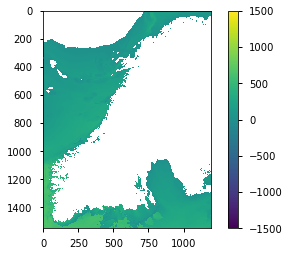

In [6]:
isot = nc_data.variables['altitude_of_0_degree_isotherm'][t_index, :, :]
print(describe(isot))
plt.imshow(np.flipud(isot), vmin=-1500, vmax=1500); plt.colorbar();

The array is of shape (1550, 1195)
The median is -297.69
The first and third quartiles are -582.37 and -110.00
The minimum is -2854.12 and the maximum is 683.63.



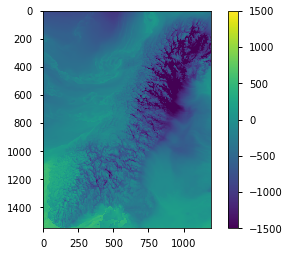

In [7]:
wetb = nc_data.variables['altitude_of_isoTprimW_equal_0'][t_index, :, :]
print(describe(wetb))
plt.imshow(np.flipud(wetb), vmin=-1500, vmax=1500); plt.colorbar();

## 0-deg isotherm for a given region

Missing value: -32768
The array is of shape (126, 91)
The median is nan
The first and third quartiles are nan and nan
The minimum is nan and the maximum is nan.



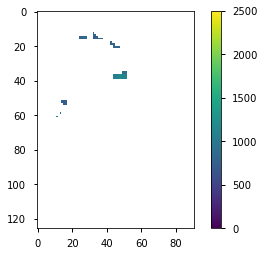

In [8]:
# Load region mask - only for data on 1km xgeo-grid
region_mask, y_min, y_max, x_min, x_max = load_region(3028)

isot_clip = region_mask * np.flipud(nc_data.variables['altitude_of_0_degree_isotherm'][20, (y_dim-y_max):(y_dim-y_min), x_min:x_max])
print(describe(isot_clip))

plt.imshow(isot_clip, vmin=0, vmax=2500); plt.colorbar();

In [9]:
# Does not work (ValueError) if all values are NaN
print("Mean:\t", np.nanmean(isot_clip))
print("Median:\t", np.nanmedian(isot_clip))

Mean:	 924.5573231871699
Median:	 --


2020-02-14 08:00:00 nan
2020-02-14 14:00:00 nan
2020-02-14 20:00:00 nan
2020-02-15 02:00:00 896.4209133097032
2020-02-15 08:00:00 821.7349253060403
2020-02-15 14:00:00 732.8390501302496
2020-02-15 20:00:00 893.787040591008
2020-02-16 02:00:00 1238.1256393732745
2020-02-16 08:00:00 1124.2582301030789
2020-02-16 14:00:00 1047.456222051381


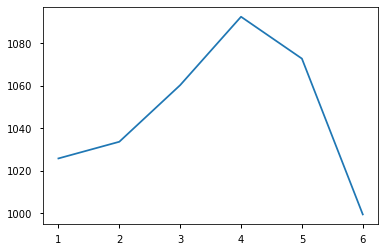

In [10]:
for k, f in enumerate(range(0, 60, 6), start=1):
    t1 = []
    ng = []
    for i, d in enumerate(range(f, f+6), start=1):
        isot_clip = region_mask * np.flipud(nc_data.variables['altitude_of_0_degree_isotherm'][d, (y_dim-y_max):(y_dim-y_min), x_min:x_max])
        _t1 = netCDF4.num2date(time_v[d], time_v.units)
        try:
            _ng = np.nanmean(isot_clip)
        except ValueError:
            _ng = 0.0
                    
#         print("\t", i, f, d, _t1, _ng, np.nanmean(isot_clip))
        t1.append(i)
        ng.append(_ng)

    ng = np.array(ng)
    print(_t1, np.mean(ng))
plt.plot(t1, ng);

When the 0-isot is below terrain elevation we do not get a useful value. In cases where there are a few points scattered over the region the statistics might be off (have to check that). 

## Wet bulb altitude for a given region

Missing value: -32768
The array is of shape (171, 141)
The median is -532.56
The first and third quartiles are -702.19 and -429.25
The minimum is -1779.69 and the maximum is -198.31.



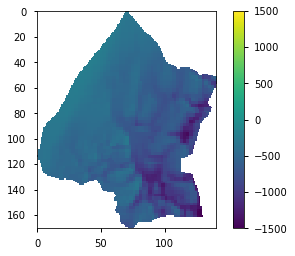

In [10]:
# Load region mask - only for data on 1km xgeo-grid
region_mask, y_min, y_max, x_min, x_max = load_region(3007)

wetb_clip = region_mask * np.flipud(nc_data.variables['altitude_of_isoTprimW_equal_0'][t_index, (y_dim-y_max):(y_dim-y_min), x_min:x_max])
print(describe(wetb_clip))

plt.imshow(wetb_clip, vmin=-1500, vmax=1500); plt.colorbar();

Calculate the median and mean over the region for each time-step and for 6 hour chunks from *night* (00-06), *morning* (06-12), *afternoon* (12-18) and *evening* (18-24)

2020-02-14 08:00:00 -468.9109293619792
2020-02-14 14:00:00 -476.184326171875
2020-02-14 20:00:00 -305.14892578125
2020-02-15 02:00:00 -506.2854817708333
2020-02-15 08:00:00 -646.6503499348959
2020-02-15 14:00:00 -796.4444580078125
2020-02-15 20:00:00 -802.7477620442709
2020-02-16 02:00:00 -818.7042643229166
2020-02-16 08:00:00 -772.3631184895834
2020-02-16 14:00:00 -663.6279093424479


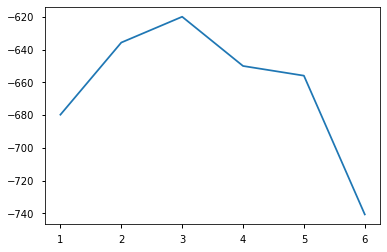

In [11]:
for k, f in enumerate(range(0, 60, 6), start=1):
    t = []
    sl = []
    for i, d in enumerate(range(f, f+6), start=1):
        wetb_clip = region_mask * np.flipud(nc_data.variables['altitude_of_isoTprimW_equal_0'][d, (y_dim-y_max):(y_dim-y_min), x_min:x_max])
        _t = netCDF4.num2date(time_v[d], time_v.units)
        _sl = np.nanmedian(wetb_clip)
#         print("\t", i, f, d, _t, _sl, np.nanmean(wetb_clip))
        t.append(i)
        sl.append(_sl)

    sl = np.array(sl)
    print(_t, np.mean(sl))
plt.plot(t, sl);

### Clip to zero

2020-02-14 08:00:00 0.0
2020-02-14 14:00:00 0.0
2020-02-14 20:00:00 0.0
2020-02-15 02:00:00 0.0
2020-02-15 08:00:00 0.0
2020-02-15 14:00:00 0.0
2020-02-15 20:00:00 0.0
2020-02-16 02:00:00 0.0
2020-02-16 08:00:00 0.0
2020-02-16 14:00:00 0.0


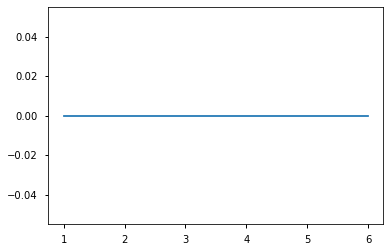

In [12]:
for k, f in enumerate(range(0, 60, 6), start=1):
    t = []
    sl = []
    for i, d in enumerate(range(f, f+6), start=1):
        wetb_clip = region_mask * np.clip(np.flipud(nc_data.variables['altitude_of_isoTprimW_equal_0'][d, (y_dim-y_max):(y_dim-y_min), x_min:x_max]), a_min=0, a_max=None)
        _t = netCDF4.num2date(time_v[d], time_v.units)
        _sl = np.nanmedian(wetb_clip)
#         print("\t", i, f, d, _t, _sl, np.nanmean(wetb_clip))
        t.append(i)
        sl.append(_sl)

    sl = np.array(sl)
    print(_t, np.mean(sl))
plt.plot(t, sl);

## Prepare precip data

The array is of shape (1550, 1195)
The median is 0.01
The first and third quartiles are 0.00 and 0.16
The minimum is 0.00 and the maximum is 26.12.



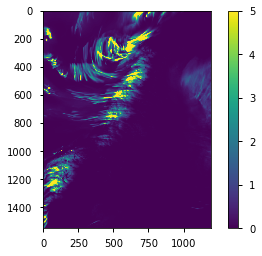

In [15]:
precip = nc_data.variables['precipitation_amount_acc'][t_index, :, :]
print(describe(precip))
plt.imshow(np.flipud(precip), vmin=0, vmax=5); plt.colorbar();

The array is of shape (126, 91)
The median is 0.11
The first and third quartiles are 0.01 and 0.68
The minimum is 0.00 and the maximum is 3.79.



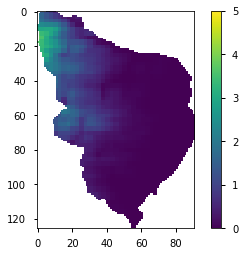

In [14]:
precip_clip = region_mask * np.flipud(nc_data.variables['precipitation_amount_acc'][t_index, (y_dim-y_max):(y_dim-y_min), x_min:x_max])
print(describe(precip_clip))

plt.imshow(precip_clip, vmin=0, vmax=5); plt.colorbar();

## Appendix A: Avalanche forecasting regions

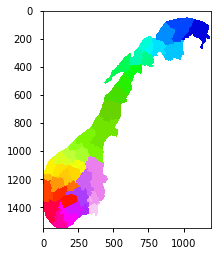

In [13]:
_vr = netCDF4.Dataset(r"../data/terrain_parameters/VarslingsOmr_2017.nc", "r")
_regions = _vr.variables["VarslingsOmr_2017"][:]

plt.imshow(_regions, vmin=3000, vmax=3048, cmap=plt.get_cmap('gist_ncar'))

## Appendix B: APS mini regions

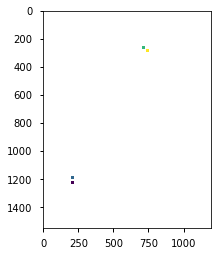

In [14]:
_local = _vr.variables["LokalOmr_2018"][:]
plt.imshow(_local)